In [37]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns

# Load dataset

In [38]:
# Read api request from a csv
df = pd.read_csv("datasets/data.csv")

# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
df = df.drop(["Unnamed: 0","temp_diff_6h", "weather.main", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,rain.1h,target
0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,NaN,0
1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,NaN,0


# Analisis descriptivo

Numerical features

In [39]:
# Check numerical features and number of nulls
exclude_features = ["dt", "weather.id"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8105.0,15.223013,4.343804,0.40,12.26,15.26,18.36,30.82,0
main.feels_like,8105.0,14.867462,4.948661,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8105.0,1016.258606,8.609523,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8105.0,83.708822,10.288154,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8105.0,14.090116,4.354793,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8105.0,16.279006,4.421052,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8105.0,3.732584,2.353262,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8105.0,183.830845,110.814811,0.00,117.00,180.00,280.00,360.00,0
wind.gust,1279.0,8.259398,5.200455,0.45,3.58,7.60,12.35,25.21,6826
clouds.all,8105.0,41.251203,35.334767,0.00,0.00,40.00,75.00,100.00,0


Categorical features

In [40]:
df['weather.id'] = df['weather.id'].astype('category')
summary = df['weather.id'].describe(include=['category']).transpose()
summary

count     8105
unique      16
top        800
freq      2190
Name: weather.id, dtype: int64

Class distribution

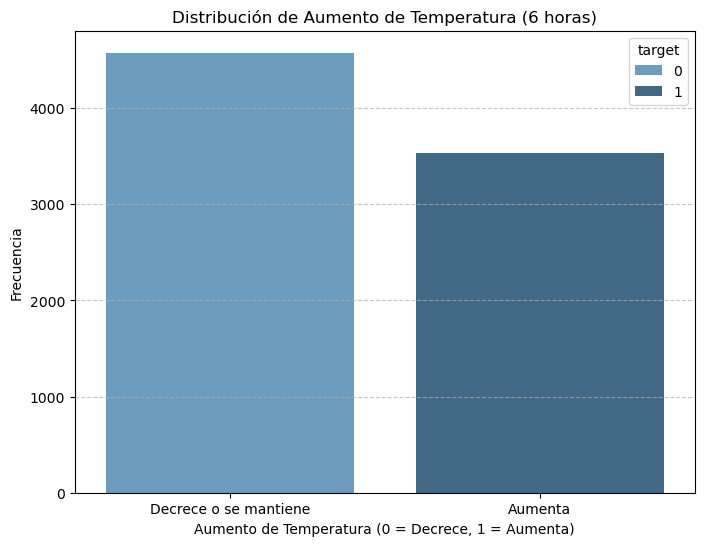

In [41]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")

# Labeling the plot
plt.xlabel("Aumento de Temperatura (0 = Decrece, 1 = Aumenta)")
plt.ylabel("Frecuencia")
plt.title("Distribución de Aumento de Temperatura (6 horas)")
plt.xticks(ticks=[0, 1], labels=['Decrece o se mantiene', 'Aumenta'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Class distribution by time

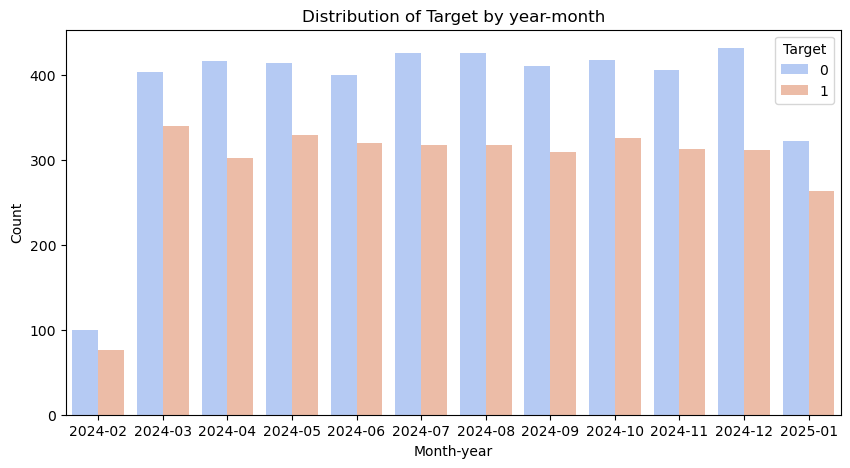

In [43]:
df["year_month"] = pd.to_datetime(df["dt"], unit="s").dt.to_period("M")

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="year_month", hue="target", palette="coolwarm")

# Labels and title
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Pipeline

In [44]:
import copy
from river import stream

def create_model(modelo):
    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.main', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h']

    def get_date_features(x):
        x["dt"] = pd.to_datetime(x["dt"], unit = "s")
        month =  x['dt'].month
        return {'month': month}

    model = get_date_features

    model |= compose.Discard(*to_discard)
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 3))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model

def stream_learning(X, y, X_test, y_test, modelo, drift_detect):
    # Almacenamos los accuracies y los indices donde hay cambios.
    drifts = []
    acc_values = []

    # Inicializamos modelo, detector de drift y metricas
    drift_detector = drift_detect()
    model = copy.deepcopy(modelo)
    acc2 = metrics.Accuracy()
    report2 = metrics.ClassificationReport()

    counter = 0
    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            print(acc2.get())
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)
        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)

        if y_pred != None:
            #Actualizamos el drift detector
            drift_detector.update(yi)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        if drift_detector.drift_detected:
            print(f'Change detected at index {counter}')
            print(acc2.get())
            # Guardar el indice donde se detecta un cambio.
            drifts.append(counter)
            # Reiniciar el modelo cuando se detecta un cambio
            model = copy.deepcopy(modelo)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        
        if y_pred != None:
            report2.update(yi, y_pred)
            acc2.update(yi, y_pred)
            #Actualizamos el drift detector
            drift_detector.update(yi)

        if counter % 100 == 0 and counter!=0:
            acc_values.append(acc2.get())
        counter += 1

    return acc_values, drifts, report2

# Train-test partition

In [46]:
test_df = df.tail(1000)
train_df = df.iloc[:-1000]

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

# Stream learning results

Results for LogisticRegression:
Accuracies: [0.6237623762376238, 0.582089552238806, 0.6146179401993356, 0.6433915211970075, 0.6227544910179641, 0.6056572379367721, 0.6248216833095578, 0.6279650436953808, 0.6204217536071032]
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      64.88%   71.51%   68.03%       558  
       1      58.70%   51.13%   54.66%       442  
                                                  
   Macro      61.79%   61.32%   61.34%            
   Micro      62.50%   62.50%   62.50%            
Weighted      62.15%   62.50%   62.12%            

                 62.50% accuracy                  


Results for HoeffdingTreeClassifier:
Accuracies: [0.6237623762376238, 0.5870646766169154, 0.6079734219269103, 0.6334164588528678, 0.6227544910179641, 0.6073211314475874, 0.5920114122681883, 0.5967540574282147, 0.5904550499445061]
Drifts: []
Report:            Precision   Recall   F1       Suppo

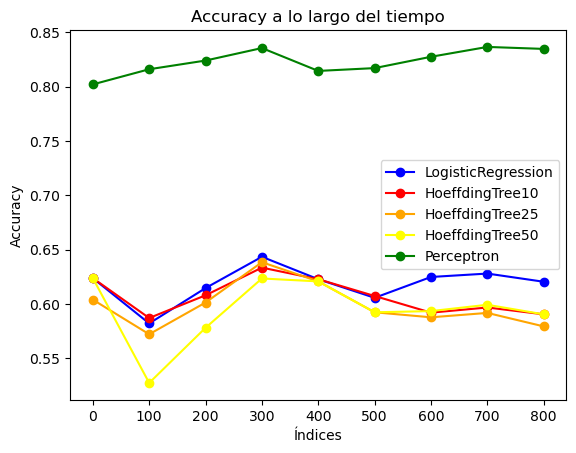

In [47]:
def get_models_results(X_train, y_train, X_test, y_test, models):
    accuracies = []
    drifts = []
    reports = []

    for model in models:
        model_instance = create_model(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test, modelo=model_instance, drift_detect=drift.ADWIN)
        
        accuracies.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("Accuracies:", accuracies[i])
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return accuracies, drifts, reports

# Muestra el resultado de dos modelos, hay que adaptarla para que saque 3.
def plot_accuracy_dual(acc_list, drifts, colors, labels):
    """
    Dibuja la precisión del modelo con detector segun van obteniendo más datos,
    permitiendo visualizar el efecto del detector.

    Parámetros:
    - acc_list: Lista con los valores de precisión para cada modelo incremental con detector.
    - drifts: Lista con los indices donde se produjeron cambios de la distribución para cada modelo.
    """

    for i, acc_values in enumerate(acc_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(acc_values))
        indices = indices*100
        plt.plot(indices, acc_values, label=label, color=color, marker='o')

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.axvline(x=value, color=color, linestyle='--', label=label[i])

    plt.legend()
    plt.xlabel('Índices')
    plt.ylabel('Accuracy')
    plt.title('Accuracy a lo largo del tiempo')
    plt.show()

# Obtain results.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=10),
          tree.HoeffdingTreeClassifier(grace_period=25),
          tree.HoeffdingTreeClassifier(grace_period=50),
          linear_model.Perceptron()]
acc, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models)

# Plot results
colors = ["blue", "red", "orange", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree10", "HoeffdingTree25", "HoeffdingTree50", "Perceptron"]
plot_accuracy_dual(acc, drifts, colors, labels)

# Batch learning results

In [50]:
def create_model(modelo):
    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.main', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h']

    def get_date_features(x):
        x["dt"] = pd.to_datetime(x["dt"], unit = "s")
        month =  x['dt'].month
        return {'month': month}

    model = get_date_features

    model |= compose.Discard(*to_discard)
    for col in cols_rolling:
        model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 3))

    model |= preprocessing.StandardScaler()
    model |= modelo

    return model


river_model = linear_model.LogisticRegression()
river_pipeline = create_model(river_model)

sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)
print(sk_pipeline)
sk_pipeline.fit(X_train,y_train)

Pipeline(steps=[('TransformerUnion',
                 River2SKLTransformer(river_estimator=TransformerUnion (
  Pipeline (
    FuncTransformer (
      func="get_date_features"
    ),
    Discard (
      Unnamed: 0
      rain.1h
      temp_diff_6h
      weather.description
      weather.icon
      weather.main
      wind.gust
    )
  ),
  Agg (
    on="main.temp"
    by=None
    how=Rolling (
      obj=Mean ()
      window_size=3
    )
  ),
  Agg (
    on="main.feels_like"
    by=None
    how=Rolling (
      obj=Mean ()
      wi...
                ('StandardScaler',
                 River2SKLTransformer(river_estimator=StandardScaler (
  with_std=True
))),
                ('LogisticRegression',
                 River2SKLClassifier(river_estimator=LogisticRegression (
  optimizer=SGD (
    lr=Constant (
      learning_rate=0.01
    )
  )
  loss=Log (
    weight_pos=1.
    weight_neg=1.
  )
  l2=0.
  l1=0.
  intercept_init=0.
  intercept_lr=Constant (
    learning_rate=0.01
  )
  clip_gra

c:\Users\Alogon\anaconda3\envs\ML2\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


KeyError: 'dt'